# Прогнозирование уровня средней заработной платы в России

In [13]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warningssm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/Users/alina/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Функция для обратоного преобразования Бокса-Кокса:

In [14]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [15]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

Посмотрим на график ряда

<Figure size 1080x504 with 0 Axes>

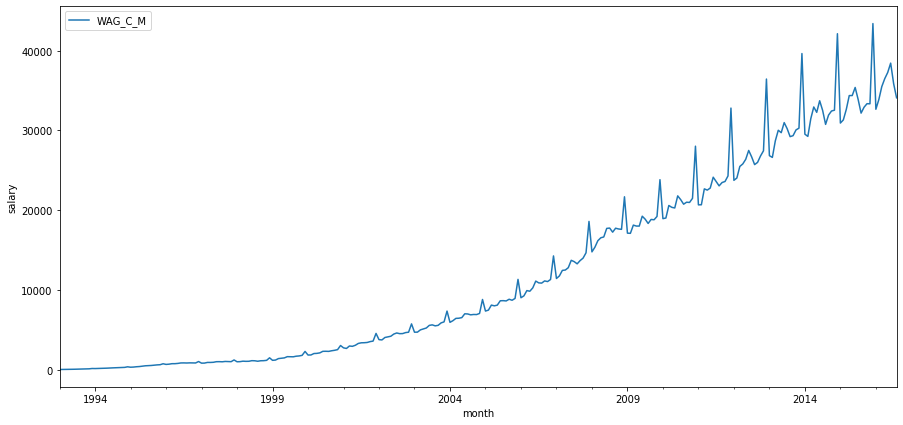

In [16]:
plt.figure(figsize(15, 7))
salary.plot()
plt.ylabel('salary')
plt.show()

Видно, что есть ярко выраженный тренд, присутствует сезонность, дисперсия неравномерная

Проверим стационарность с помощью критерия Дики-Фулера и посмотрим на STL-декомпозицию ряда

In [19]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary)[1])

Критерий Дики-Фуллера: p=0.991850


Гипотеза о нестационарности не отвергается, что достаточно хорошо видно на графике

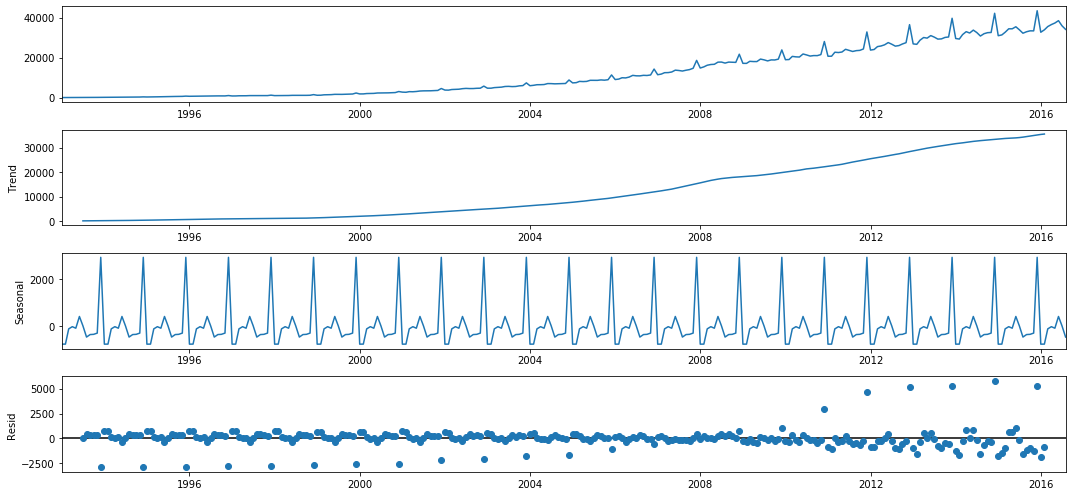

In [21]:
sm.tsa.seasonal_decompose(salary).plot()
plt.show()

## Преобразование Бокса-Кокса для стабилизации дисперсии


Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


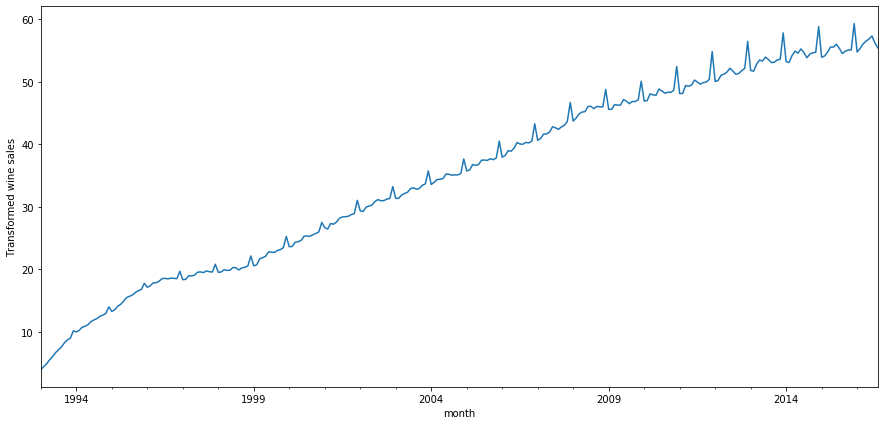

In [23]:
salary['box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box)[1])

## Стационарность

В данных есть ярко выраженный тренд, поэтому нужно продифференцировать ряд, чтобы сделать его стационарным

Попробуем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

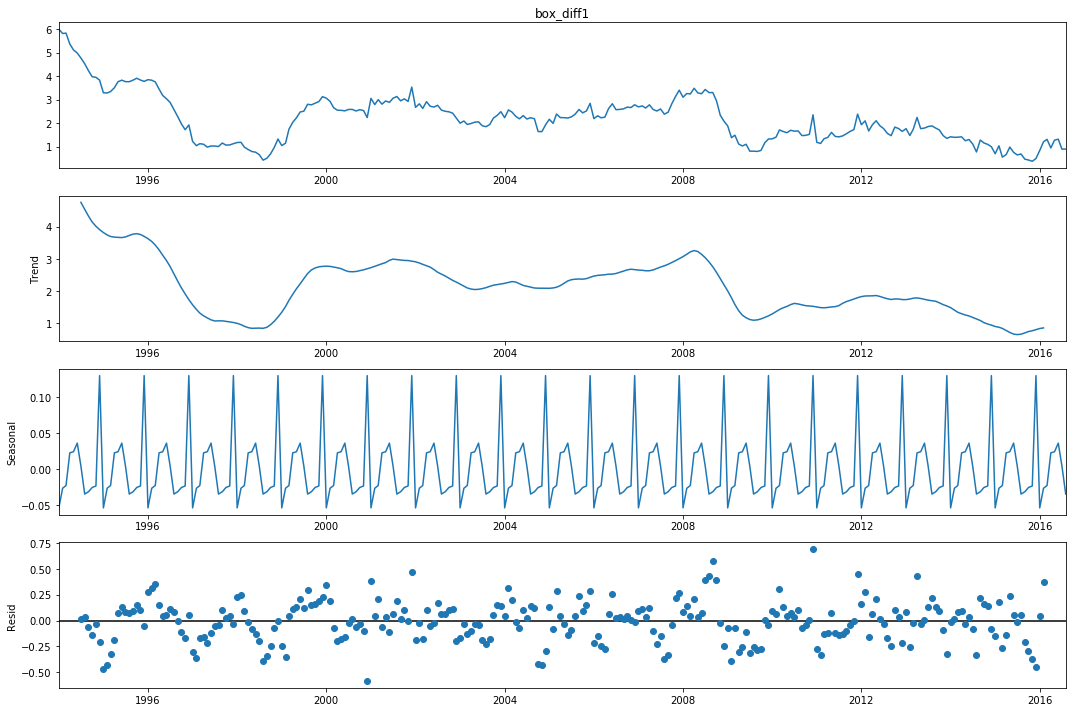

In [24]:
salary['box_diff1'] = salary.box - salary.box.shift(12)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(salary.box_diff1[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff1[12:])[1])

Критерий Дики-Фулера отвергает нестационарность, однако визуально тренд виден, поэтому попробуем дальше дифференцировать

Попробуем обычное дифференцирование

Критерий Дики-Фуллера: p=0.014396


<Figure size 1080x720 with 0 Axes>

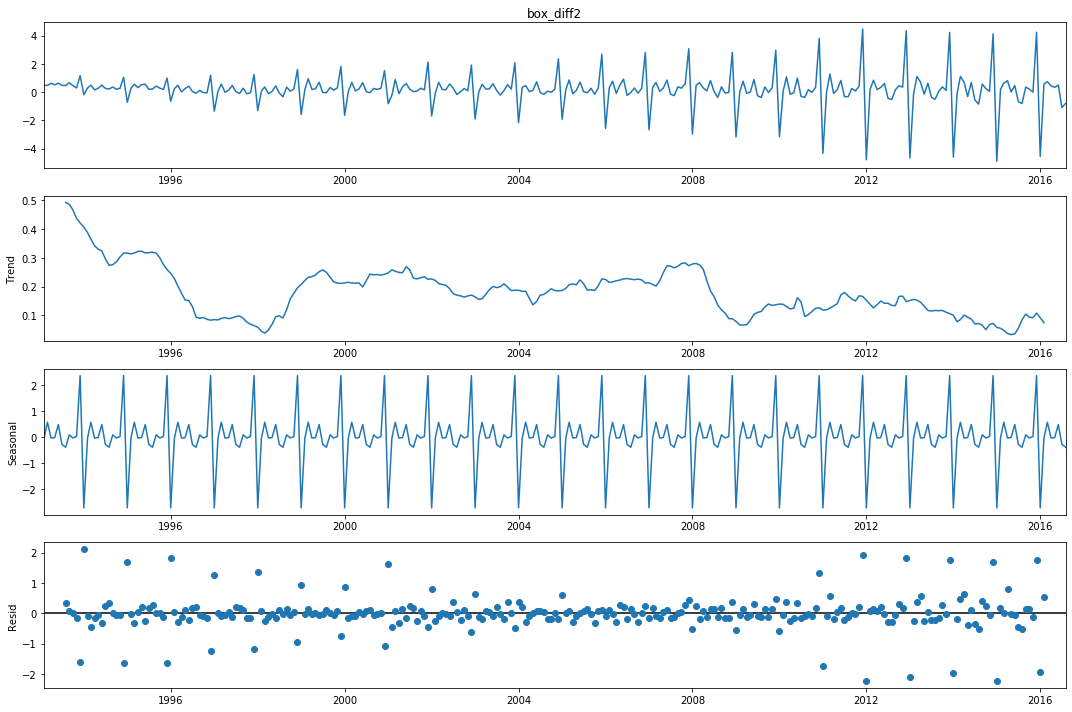

In [25]:
salary['box_diff2'] = salary.box - salary.box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff2[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff2[1:])[1])

Тут также критерий опровергает нестационарность, но тренд виден визуально

Добавим обычное дифференцирование к сезонному

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

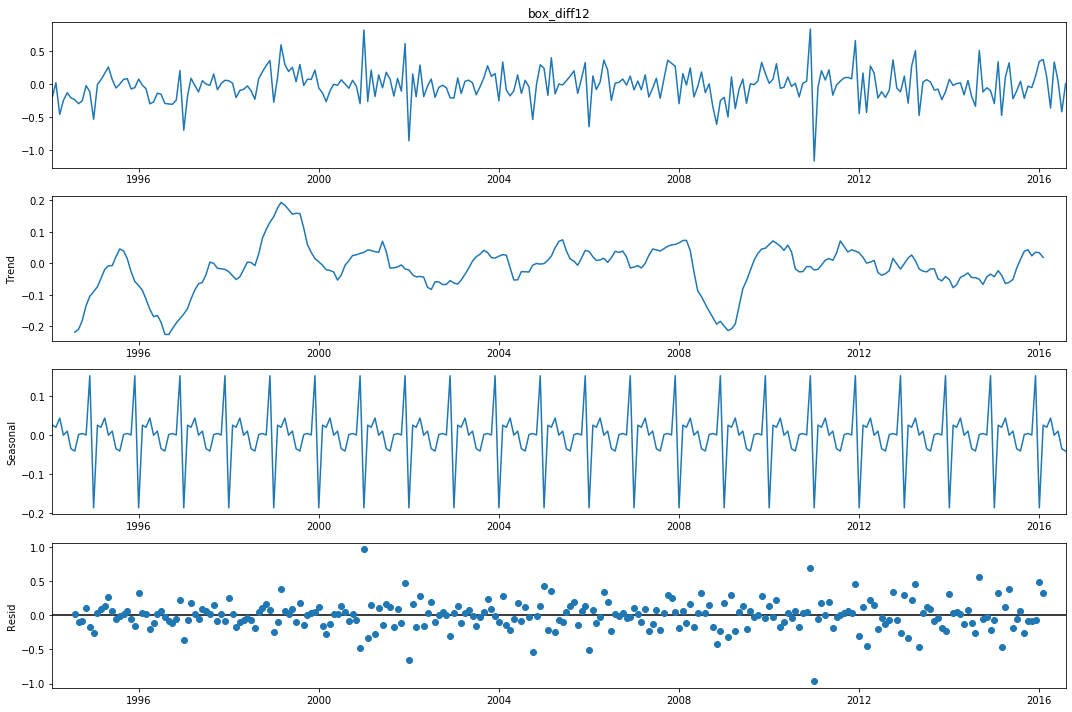

In [26]:
salary['box_diff12'] = salary.box_diff1 - salary.box_diff1.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.box_diff12[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.box_diff12[13:])[1])

Здесь видно, что тренд колеблется вокруг некоторого значения и нестационарность уверенно отвергается

## Подберем модель
Для подборо параметров модели построим автокоррреляционную и частнично автокоррреляционную функции

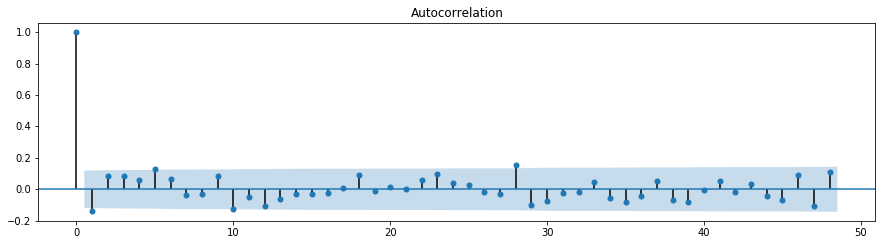

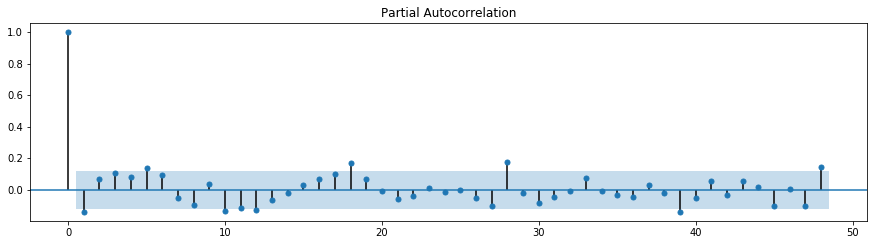

In [30]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.box_diff12[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.box_diff12[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения:
- Q=0
- q=1
- P=1
- p=10

In [67]:
ps = range(8, 12)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [68]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [69]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 4min 26s, sys: 1.48 s, total: 4min 27s
Wall time: 1min 19s


In [70]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
32  (10, 2, 0, 0) -17.497879
44  (11, 2, 0, 0) -16.631059
33  (10, 2, 0, 1) -15.539955
34  (10, 2, 1, 0) -15.537092
35  (10, 2, 1, 1) -13.652937


In [71]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  box   No. Observations:                  284
Model:             SARIMAX(10, 1, 2)x(0, 1, [], 12)   Log Likelihood                  21.749
Date:                              Sun, 02 Aug 2020   AIC                            -17.498
Time:                                      14:04:52   BIC                             29.330
Sample:                                  01-01-1993   HQIC                             1.304
                                       - 08-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3298      0.077     17.247      0.000       1.179       1.481
ar.L2         -0.48

## Остатки модели

Критерий Стьюдента: p=0.112335
Критерий Дики-Фуллера: p=0.000000


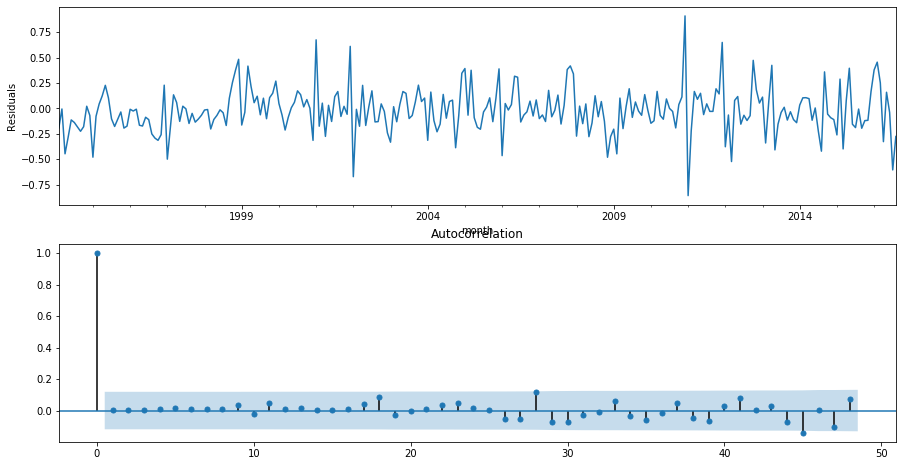

In [72]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

- Критерий Стьюдент показывает, что остатки несмещены
- Критерий Дики-Фулера подтверждает, что остатки стационарны, это видно и визуально
- Авктокорреляционный график показывает, что остатки неавтокоррелированы

Посмотрим, как модель описывает данные:

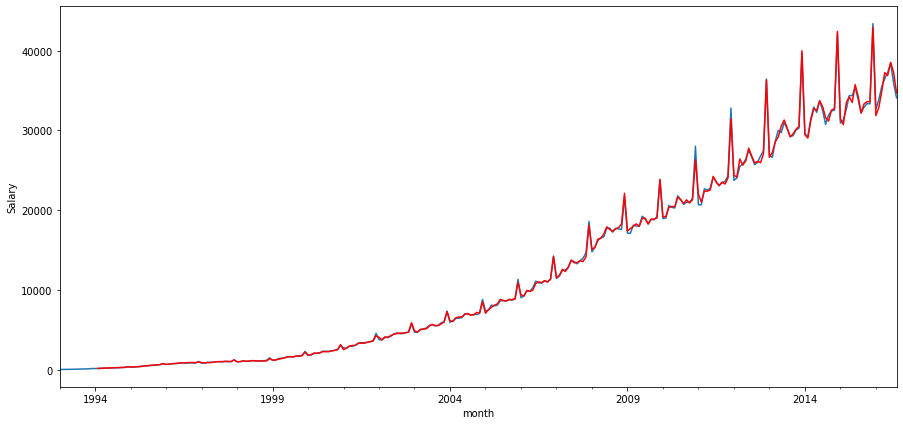

In [73]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

## Построим прогноз

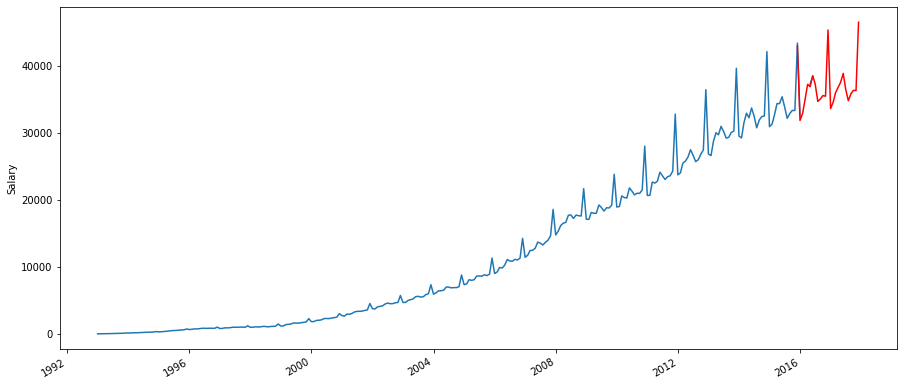

In [94]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=275, end=300), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()